# Логистическая регрессия

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import fetch_openml
import seaborn as sns
import matplotlib.pyplot as plt 

# Устанавливаем стиль визуализаций в matplotlib
%matplotlib inline
plt.style.use('seaborn')

from warnings import simplefilter
simplefilter('ignore')

В **задаче классификации** нужно предсказать класс объекта на основе признаков в наборе данных.\
Задача сводится к предсказанию целевого признака, который является **категориальным**.

Если **классов**, которые нужно предскзать, только **два**, то классификация называется **бинарной**.

Когда **классов**, которые нужно предскзать, **более двух**, то классификация называется **мультиклассовой (многоклассовой)**.

> Модели, которые решают задачу классификации, называются **классификаторами (classifier)**.

Для начала рассмотрим бинарную классификацию.

В основе логистической регрессии лежит **логистическая функция (logistic function)** — отсюда и название модели.\
Более распространённое название этой функции — **сигмόида (sigmoid)**. \
Записывается она следующим образом:
$$ \sigma(z) = \frac{1}{1+e^{-z}} $$

Где $e$ — экспонента или [число Эйлера](https://dzen.ru/a/XKW4kcYE3AId802p). \
Бесконечная десятичная дробь, которую обычно принимают равной $2.718...$ \
Построим сигмоиду для наглядности.

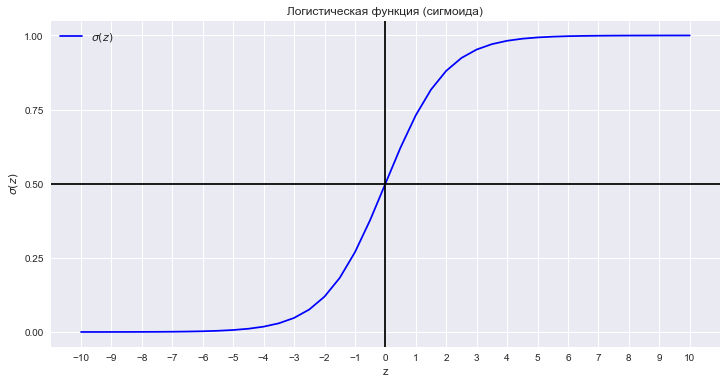

In [2]:
# фигура + координатная плоскость
fig, ax = plt.subplots(figsize=(12, 6)) 

# точки по осям
z_items = np.arange(-10, 10.5, 0.5, dtype=None)
sigma_items = 1 / (1 + np.exp(-1*z_items))

# график сигмоиды
ax.plot(z_items, sigma_items, color='blue', label='$\sigma(z)$') 

# ось абсцисс  
ax.axhline(y=0.5, color='black')
# ось ординат
ax.axvline(x=0, color='black')

# название графика
ax.set_title('Логистическая функция (сигмоида)')
# название оси абсцисс
ax.set_xlabel('z')     
# название оси ординат
ax.set_ylabel('$\sigma(z)$') 

# метки по оси абсцисс
ax.set_xticks(np.arange(-10, 11, 1, dtype=None))
# метки по оси ординат
ax.set_yticks(np.arange(0, 1.25, 0.25, dtype=None))
    
# легенда
ax.legend(facecolor='white', fontsize=11) 

Функция сигмоиды реализована в [scipy.stats.logistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.logistic.html) и [scipy.special.expit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html).

У сигмоиды есть два важных свойства:

- Значения сигмоиды $\sigma(z)$ лежат в диапазоне от 0 до 1 при любых значения аргумента $z$.

- Сигмоида выдаёт значения $\sigma(z)>0.5$ при аргументе $z>0$, \
$\sigma(z)<0.5$ — при $z<0$ \
и $\sigma(z)=0.5$ — при $z=0$.

А это свойства вероятности. \
Выходом сигмоиды является число от 0 до 1, \
которое можно интерпретировать как вероятность принадлежности к классу 1.

**Основная идея модели логистической регрессии**: 

модель линейной регрессии (обозначим её выход за $z$)
$$ z=w_{0}+\sum_{j=1}^{m} w_{j} x_{j} $$

подставляется в функцию сигмоиды, чтобы получить искомые оценки вероятности \
(оценочные величины обозначаются с «шапкой» наверху, а истинные значения — без «шапки»):

$$ \hat{P}=\sigma(z)=\frac{1}{1+e^{-z}}=\frac{1}{1+e^{-w_{0}-\sum_{j=1}^{m} w_{j} x_{j}}}=\frac{1}{1+e^{-\bar{w} \cdot \bar{x}}} $$

Далее для краткости будем использовать слово "**вероятность**", но подразумевается именно **оценка вероятности**.

Если вероятность $\hat{P} > 0.5$, относим объект к классу 1, \
а если $\hat{P} \leq 0.5$, относим объект к классу 0. 

Данное условие записывается с помощью **индикаторной функции**:

$$ \hat{y}=I[\hat{P}]=\left\{\begin{array}{l} 1, \hat{P}>0.5 \\ 0, \hat{P} \leq 0.5 \end{array}\right. $$

Так задача классификации сводится к задаче регрессии для предсказания вероятностей. 

Полученное выражение для оценки вероятности $\hat{P}$ называется моделью логистической регрессии:
$$ \hat{P}=\frac{1}{1+e^{-w_{0}-\sum_{j=1}^{m} w_{j} x_{j}}} $$
$$ \hat{y}=I[\hat{P}] $$

**Для понимания геометрической интерпретации рассмотрим частный случай.**

Пусть класс объекта зависит от двух признаков.\
Если рассматривать уравнение линейной регрессии отдельно от сигмоиды, \
то геометрически построить логистическую регрессию на основе двух факторов — \
значит найти такие коэффициенты $w_0$, $w_1$ и $w_2$ уравнения плоскости, \
при которых наблюдается наилучшее разделение пространства на две части.
$$ z = w_{0} + w_{1}x_{1} + w_{2}x_{2} $$

Математически подстановка в уравнение плоскости точки, которая не принадлежит ей (находится ниже или выше), \
означает вычисление расстояния от этой точки до плоскости.

- Если точка находится ниже плоскости, расстояние будет отрицательным ($z < 0$).
- Если точка находится выше плоскости, расстояние будет положительным ($z > 0$).
- Если точка находится на самой плоскости, $z = 0$.

Подстановка отрицательных чисел в сигмоиду приведёт к вероятности $\hat P < 0.5$, \
а постановка положительных — к вероятности $\hat P > 0.5$,. 

Таким образом, ключевым моментом в предсказании логистической регрессии \
является расстояние от точки до разделяющей плоскости в пространстве факторов. \
Это расстояние в литературе часто называется **отступом (margin)**. 

Чем больше расстояние от точки, находящейся выше разделяющей плоскости, до самой плоскости, \
тем больше оценка вероятности принадлежности к классу 1.

В общем случае, когда есть зависимость от $m$ факторов, \
линейное выражение, находящееся под сигмоидой, \
будет обозначать **разделяющую гиперплоскость**.

## Поиск параметров логистической регрессии

Для поиска параметров логистической регрессии используется \
**метод максимального правдоподобия (Maximum Likelihood Estimation — MLE)**. 

> **Правдоподобие** — это оценка того, насколько вероятно получить \
истинное значение целевой переменной $y$ при данных $x$ и параметрах $w$. 

**Цель метода** — найти такие параметры $w=(w_{0}, w_{1}, w_{2}, ..., w_{m})$, \
в которых наблюдается максимум функции правдоподобия:

$$ likelihood = \sum_{i}^{n} (y_{i} log (\hat{P_{i}}) + (1-y_{i}) log (1-\hat{P_{i}})) \rightarrow max_{w} $$

[Подробнее о выводе](https://habr.com/ru/articles/485872/)

Где:
- $n$ — количество наблюдений.
- $y_{i}$ - это истинный класс (1 или 0) для $i$-ого объекта из набора данных.
- $\hat{P_{i}} = \sigma(z_{i})$ — предсказанная с помощью логистической регрессии \
вероятность принадлежности к классу 1 для $i$-ого объекта из набора данных.
    - $z_{i}$ — результат подстановки $i$-ого объекта из набора данных \
    в уравнение разделяющей плоскости $z_{i}= \bar{w} \cdot \bar{x_{i}}$.
- $log$ — логарифм (обычно используется натуральный логарифм по основанию $e - ln$).

Если перед функцией поставить знак минус, то задача меняется на противоположную.\
С поиска максимума на поиск минимума.\
Таким образом получим функцию потерь $L(w)$, \
которая носит название «**функция логистических потерь**», или **logloss**. \
Также часто можно встретить название **кросс-энтропия**, или **cross-entropy loss**:
$$ L(w) = \text { logloss } =-\sum_{i}^{n} (y_{i} log (\hat{P_{i}}) + (1-y_{i}) log (1-\hat{P_{i}})) \rightarrow min_{w} $$
$$ \hat{P_{i}}=\frac{1}{1+e^{-w_{0}-\sum_{j=1}^{m} w_{j} x_{j}}} $$

Эта функция минимизируется в рамках поиска параметров логистической регрессии.\
Данная задача решается численным методом (при расчетах получается, что аналитического решения не существует).

Например, можно использовать градиентный спуск. \
Итерационная формула данного метода выглядит следующим образом:

$$ \omega^{(k+1)}=\omega^{(k)}-\eta \nabla L\left(\omega^{(k)}\right) $$

новое значение параметров $w^{(k+1)}$ \
получается путём сдвига текущих $w^{(k)}$ \
в сторону вектора антиградиента $- \nabla L (w^{(k)})$, \
умноженного на темп обучения $\eta$.

**Формула градиентного спуска для logloss** 
$$ L(w)=-\sum_{i}^{n}\left(y_{i} \log \left(\sigma\left(w x_{i}\right)\right)+\left(1-y_{i}\right) \log \left(1-\sigma\left(w x_{i}\right)\right)\right) $$
$$ \nabla L(w)=-\sum_{i}^{n} x_{i}\left(y_{i}-\sigma\left(w x_{i}\right)\right) $$
$$ w^{(k+1)}=w^{(k)}-\eta \nabla L\left(w^{(k)}\right)=w^{(k)}+\eta \sum_{i}^{n} x_{i}\left(y_{i}-\sigma\left(w^{(k)} x_{i}\right)\right) $$

Для того, чтобы повысить шанс пройти мимо локальных минимумов функции потерь, \
используется не сам градиентный спуск, а его модификации: \
например, можно использовать стохастический градиентный спуск (SGD).

Перед применением градиентного спуска необходимо масштабировать данные (нормализовать / стандартизировать).\
Во избежание переобучения модели в функцию потерь логистической регрессии традиционно добавляется **регуляризация**.

При L1-регуляризации в функцию потерь $L(w)$ добавляется штраф из суммы модулей параметров, \
а сама функцию logloss умножается на коэффициент $C$:

$$ L(w)=C \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min_{w} $$

А при L2-регуляризации добавляется штраф из суммы квадратов параметров:

$$ L(w)=C \cdot \log \operatorname{loss}+\sum_{j=1}^{m}\left(w_{j}\right)^{2} \rightarrow \min _{w} $$

Значение коэффициента $C$ — коэффициент, обратный коэффициенту регуляризации. \
Чем больше $C$, тем меньше «сила» регуляризации.

Можно разделить всё соотношение на коэффициент $C$:
$$ \frac{L(w)}{C}=\log \operatorname{loss}+\frac{1}{C} \sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min _{w} $$

Оказывается, параметры $w$, при которых достигается минимум $L(w)$ и $\frac{L(w)}{C}$ одни и те же, \
так как функции отличаются только на константу. \
А значит, нет разницы, минимум какой функции искать — $L(w)$ или $\frac{L(w)}{C}$. \
Тогда формула будет записана в следующем виде:
$$ L(w)=\log \operatorname{loss}+\frac{1}{C} \sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min _{w} $$

А если обозначить $\alpha=\frac{1}{C}$, то получим ту же самую структуру L1-регуляризации, что и для логистической регрессии:

$$ L(w)=\log \operatorname{loss}+\alpha \sum_{j=1}^{m}\left|w_{j}\right| \rightarrow \min _{w} $$

Вывод: коэффициент $C$ — это коэффициент, обратный коэффициенту регуляризации $\alpha$.

## Реализация логистической регрессии в sklearn

Класс логистической регрессии **LogisticRegression** находится в модуле **sklearn.linear_model**.

**Основные параметры LogisticRegression**

- `random_state` — число, на основе которого происходит генерация случайных чисел.
- `penalty` — метод регуляризации. Возможные значения:
    - `'l1'` — L1-регуляризация;
    - `'l2'` — L2-регуляризация (используется по умолчанию);
    - `'elasticnet'` — эластичная сетка (L1+L2);
    - `'None'` — отсутствие регуляризации.
- `C` — коэффициент обратный коэффициенту регуляризации, то есть равен $\frac{1}{\alpha}$\
. Чем больше `C`, тем меньше регуляризация. По умолчанию `C=1`, тогда `α=1`.
- `solver` — численный метод оптимизации функции потерь logloss, может быть:
    - `'sag'` — стохастический градиентный спуск (нужна стандартизация/нормализация);
    - `'saga'` — модификация предыдущего, которая поддерживает работу с негладкими функциями \
    (нужна стандартизация/нормализация);
    - `'newton-cg'` — [метод Ньютона с модификацией сопряжённых градиентов](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#newton-conjugate-gradient-algorithm-method-newton-cg) \
    (не нужна стандартизация/нормализация);
    - `'lbfgs'` — [метод Бройдена — Флетчера — Гольдфарба — Шанно](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE) \
    (не нужна стандартизация/нормализация; используется по умолчанию, \
    так как из всех методов теоретически обеспечивает наилучшую сходимость);
    - `'liblinear'` — [метод покоординатного спуска](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BF%D0%BE%D0%BA%D0%BE%D0%BE%D1%80%D0%B4%D0%B8%D0%BD%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%81%D0%BF%D1%83%D1%81%D0%BA%D0%B0) \
    (не нужна стандартизация/нормализация).
- `max_iter` — максимальное количество итераций, выделенных на сходимость.

In [3]:
# Для примера возьмем данные о диабете
diabetes_data_full = fetch_openml(name='diabetes')
diabetes_data = diabetes_data_full['frame']
diabetes_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive


In [4]:
# Заменим в целевом признаке значение tested_positive на 1, а tested_negative на 0
diabetes_data['class'] = diabetes_data['class'].apply(lambda x: 1 if x == 'tested_positive' else 0)
diabetes_data['class'] = diabetes_data['class'].astype(int)

In [5]:
# признаки
X = diabetes_data.drop(['class'], axis=1)
# целевой признак
y = diabetes_data['class']

# разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# создаём объект класса LogisticRegression
logistic_regression_model = LogisticRegression(random_state=42, max_iter=1000)

# Обучаем модель, минимизируя logloss
logistic_regression_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Метод **predict_proba()** возвращает две вероятности: \
первая соответствует вероятности принадлежности к классу 0 (диабета нет), \
а вторая — вероятности принадлежности к классу 1 (диабет есть). \
В сумме две вероятности дают 1.

In [7]:
y_test_predict_proba = logistic_regression_model.predict_proba(X_test)
# Посмотрим на первые 5 пар значений
y_test_predict_proba[:5]

array([[0.72812239, 0.27187761],
       [0.80754375, 0.19245625],
       [0.88916879, 0.11083121],
       [0.85489122, 0.14510878],
       [0.51653373, 0.48346627]])

Метод **predict()** предсказывает класс. \
По умолчанию метод **predict()** относит объект к классу 1, \
если вероятность принадлежности к классу 1 > 0.5, \
и к классу 0, если эта вероятность < 0.5.

In [8]:
y_test_predict = logistic_regression_model.predict(X_test)
# Посмотрим на первые 5 пар значений
y_test_predict[:5]

array([0, 0, 0, 0, 0])

Выведем метрики.

In [9]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       123
           1       0.61      0.64      0.62        69

    accuracy                           0.72       192
   macro avg       0.70      0.71      0.70       192
weighted avg       0.73      0.72      0.73       192



In [10]:
# выводим результирующие коэффициенты

# свободный член w0
print(f'w0: {logistic_regression_model.intercept_}') 

# остальные параметры модели w1, w2, ..., wm
print(f'wi: {logistic_regression_model.coef_}') 

w0: [-9.2883952]
wi: [[ 0.06102614  0.03600031 -0.01261277  0.00464533 -0.00157649  0.1017979
   0.45706892  0.03788837]]


### Подбор порога вероятности

Напишем функцию для подбора оптимального порога вероятности с помощью графика.

In [11]:
def show_metrics_for_probability_thresholds(X: pd.DataFrame, y: pd.Series):
    """Выводит графики значения метрик Recall/Precision/F1 в зависимости от порога вероятности

    Args:
        X (pd.DataFrame): факторы
        y (pd.Series): целевой признак
    """
    # считаем вероятности наличия диабета для каждого из пациентов
    # берем только вероятность класса 1 (второй столбец)
    y_predict_proba = logistic_regression_model.predict_proba(X)[:, 1]
    
    # для удобства завернём numpy-массив в Pandas Series
    y_predict_proba = pd.Series(y_predict_proba)
    
    # создадим списки, в которых будем хранить значения метрик 
    recall_scores = []
    precision_scores = []
    f1_scores = []
    
    # сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
    thresholds = np.arange(0.1, 1, 0.05)
    
    # d цикле будем перебирать сгенерированные пороги
    for threshold in thresholds:
        # пациентов, для которых вероятность наличия диабета > threshold, относим к классу 1
        # в противном случае — к классу 0
        y_predict = y_predict_proba.apply(lambda x: 1 if x > threshold else 0)
        
        # cчитаем метрики и добавляем их в списки
        recall_scores.append(metrics.recall_score(y, y_predict))
        precision_scores.append(metrics.precision_score(y, y_predict))
        f1_scores.append(metrics.f1_score(y, y_predict))
    
    # визуализируем метрики при различных threshold
    # фигура + координатная плоскость
    fig, ax = plt.subplots(figsize=(16, 8)) 

    # cтроим линейный график зависимости recall от threshold
    ax.plot(thresholds, recall_scores, label='Recall')

    # cтроим линейный график зависимости precision от threshold
    ax.plot(thresholds, precision_scores, label='Precision')

    # cтроим линейный график зависимости F1 от threshold
    ax.plot(thresholds, f1_scores, label='F1-score')
    
    # название графика и осей
    ax.set_title('Значения метрик Recall/Precision/F1 в зависимости от выбранного порога вероятности')
    ax.set_xlabel('Порог вероятности')
    ax.set_ylabel('Значение метрик')

    # отметки по оси x
    ax.set_xticks(thresholds) 

    # легенда
    ax.legend();

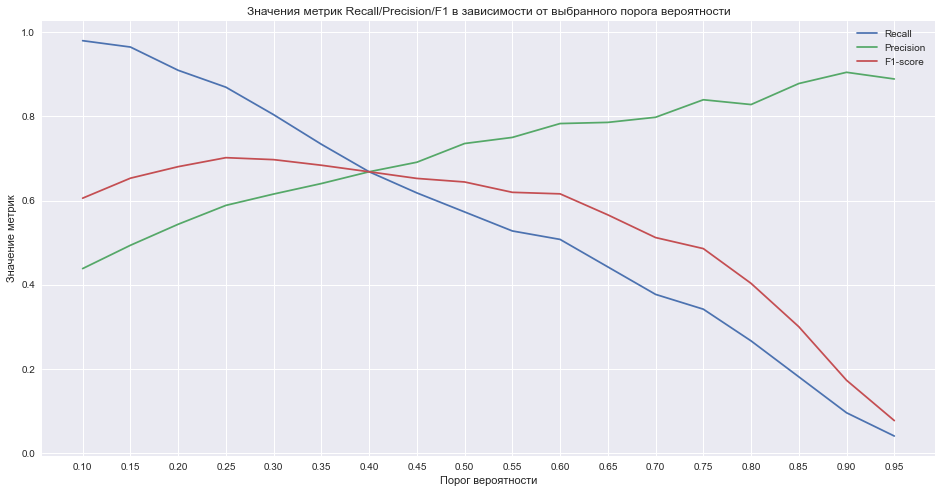

In [12]:
# посмотрим на графики метрик для тренировочной выборки
show_metrics_for_probability_thresholds(X_train, y_train)

Оптимальным значением является порог вероятности `0.4`.\
Так как значения метрик `Recall` и `Precision` для него равны.

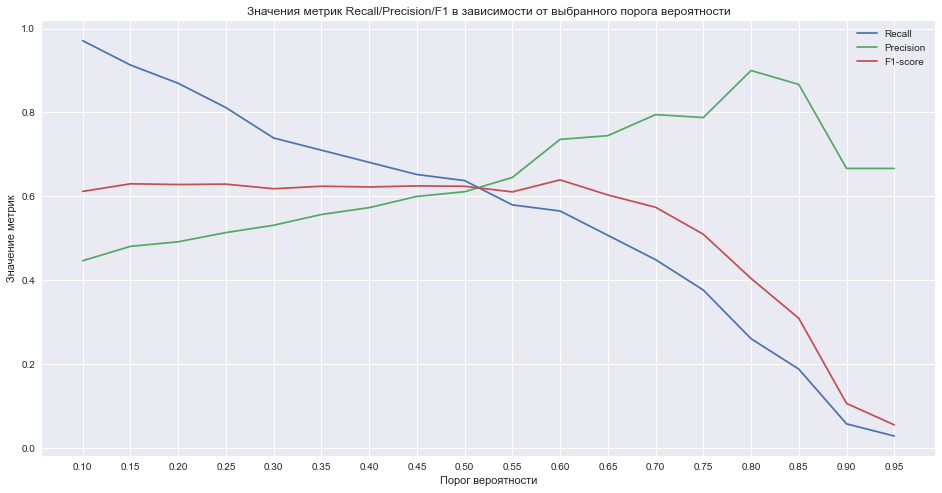

In [13]:
show_metrics_for_probability_thresholds(X_test, y_test)

А для тестовой выборки больше подходит значение, близкое к `0.51`, \
так как в нем равны значения метрк `Recall` и `Precision`.

Правильней взять значение `0.4` (для тренировочной выборки)\
И стоит иметь в виду, что выбранный порог не всегда подойдет для новых данных.

## Логистическая регрессия с полиномиальными признаками

Для построения модели логистической регрессии можно использовать полиномиальные признаки (аналогично [линейной регрессии](./linear_regression.ipynb)).\
И в этом случае также необходимо добавлять регуляризацию во избежание переобучения модели.

## Мультиклассовая классификация

Когда **классов**, которые нужно предскзать, **более двух**, то классификация называется **мультиклассовой (многоклассовой)**

Если у нас есть $k$ различных классов ($k>2$), \
то модель строит $k$ классификаторов, \
каждый из которых будет предсказывать вероятности принадлежности каждого объекта \
к определённому классу.

Итоговый классификатор будет выдавать класс, который соответствует самой «уверенной» модели.

Схематически это можно представить следующим образом.

<div style="width: 100%;"><div style="position: relative; padding-bottom: 56.25%; padding-top: 0; height: 0;"><iframe title="" frameborder="0" width="1200px" height="675px" style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;" src="https://github.com/experiment0/data_science_helpers/blob/master/articles/mermaid/logistic-regression-multiclass.md" type="text/html" allowscriptaccess="always" allowfullscreen="true" scrolling="yes" allownetworking="all"></iframe> </div> </div>

```mermaid
flowchart LR
    %% Блоки
    Factors("`Новые факторы:
    Фактор 1
    Фактор 2
    ...
    Фактор m
    `")

    Model0("Модель '0 vs other'")
    Model1("Модель '1 vs other'")
    Model2("Модель '2 vs other'")

    Maximum("Максимум из вероятностей")

    Result("Предсказанный класс 1")
    
    %% Связи
    Factors-->Model0
    Factors-->Model1
    Factors-->Model2

    Model0-->|0.3|Maximum
    Model1-->|0.61|Maximum
    Model2-->|0.09|Maximum

    Maximum-->Result
```

Пусть мы построили несколько разделяющих плоскостей с различными наборами параметров $k$, \
где $k$ — номер классификатора. \
То есть имеем $K$ разделяющих плоскостей:

$$ z_{k}=w_{0 k}+\sum_{j=1}^{m} w_{j k} x_{j}=w_{k} \cdot x $$

Чтобы преобразовать результат каждой из построенных моделей в вероятности в логистической регрессии, \
используется функция **softmax** — многомерный аналог сигмоиды:

$$ \hat{P}_{k}=\operatorname{softmax}\left(z_{k}\right)=\frac{\exp \left(\hat{y}_{k}\right)}{\sum_{k=1}^{K} \exp \left(\hat{y}_{j k}\right)} $$

Данная функция выдаёт нормированные вероятности, \
то есть в сумме для всех классов вероятность будет равна 1.

In [35]:
# Возьмем датасет с пинвинами
penguins_data = sns.load_dataset('penguins')
penguins_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Описание столбцов:
- **species** — класс пингвина ('Adelie', 'Chinstrap', 'Gentoo'), целевой признак;
- **island** — остров, на котором живёт пингвин ('Torgersen', 'Biscoe', 'Dream');
- **bill_length_mm** — длина клюва в миллиметрах;
- **bill_depth_mm** — толщина клюва в миллиметрах;
- **flipper_length_mm** — длина крыльев;
- **body_mass_g** — масса;
- **sex** — пол ('Male', 'Female').

In [36]:
# Посмотрим на пропуски
penguins_data.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [37]:
# Удалим пропуски
penguins_data = penguins_data.dropna()

In [38]:
# Заменим признак пола на бинарный
penguins_data['sex'] = penguins_data['sex'].apply(lambda x: 1 if x == 'Male' else 0)

In [39]:
# факторы
X = penguins_data.drop('species', axis=1)
# целевой признак
y = penguins_data['species']

X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,1
1,Torgersen,39.5,17.4,186.0,3800.0,0
2,Torgersen,40.3,18.0,195.0,3250.0,0
4,Torgersen,36.7,19.3,193.0,3450.0,0
5,Torgersen,39.3,20.6,190.0,3650.0,1


> **Примечание**. Кодировать целевую переменную **y** не нужно, \
даже если она представлена в виде строковых значений. \
Это не влияет на работу модели.

In [40]:
# Закодируем категориальные признаки
X_dummies = pd.get_dummies(X)
X_dummies.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,1,0,0,1
1,39.5,17.4,186.0,3800.0,0,0,0,1
2,40.3,18.0,195.0,3250.0,0,0,0,1
4,36.7,19.3,193.0,3450.0,0,0,0,1
5,39.3,20.6,190.0,3650.0,1,0,0,1


In [41]:
# разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.25, random_state=42)

Для мультиклассовой классификации необходимо выставить параметр `multi_class` на `multinomial`.

In [42]:
# создаём объект класса LogisticRegression
logistic_regression_multiclass_model = LogisticRegression(
    # мультиклассовая классификация
    multi_class='multinomial', 
    # количество итераций, выделенных на сходимость
    max_iter=1000, 
    # генерация случайных чисел
    random_state=42 
)
 
# обучаем модель 
logistic_regression_multiclass_model.fit(X_train, y_train)

# делаем предсказание вероятностей
y_test_pred_proba = np.round(logistic_regression_multiclass_model.predict_proba(X_test), 2)

# делаем предсказание класса
y_train_pred = logistic_regression_multiclass_model.predict(X_train)
y_test_pred = logistic_regression_multiclass_model.predict(X_test)

Сделаем таблицу из вероятностей для каждого класса и финального предсказания. 

In [43]:
# создаём DataFrame из вероятностей
y_test_pred_proba_df = pd.DataFrame(
    y_test_pred_proba, 
    columns=['Adelie', 'Chinstrap', 'Gentoo']
)

# создаём DataFrame из предсказанных классов
y_test_pred_df = pd.DataFrame(
    y_test_pred, 
    columns=['Predicted Class']
)

# объединяем таблицы по вертикальной оси
y_test_pred_result_df = pd.concat([y_test_pred_proba_df, y_test_pred_df], axis=1)

# Выбираем пять случайных строк
y_test_pred_result_df.sample(5, random_state=42)

,Adelie,Chinstrap,Gentoo,Predicted Class
73,0.00,0.00,1.0,Gentoo
0,0.48,0.52,0.0,Chinstrap
58,0.00,1.00,0.0,Chinstrap
22,0.00,0.00,1.0,Gentoo
12,0.00,0.00,1.0,Gentoo


Видно, что выбирается класс, вероятность принадлежности к которому максимальна.

In [44]:
# Посмотрим на метрики для тренировочной выборки
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

      Adelie       1.00      0.99      1.00       106
   Chinstrap       0.98      1.00      0.99        53
      Gentoo       1.00      1.00      1.00        90

    accuracy                           1.00       249
   macro avg       0.99      1.00      1.00       249
weighted avg       1.00      1.00      1.00       249



In [45]:
# Посмотрим на метрики для тестовой выборки
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        40
   Chinstrap       0.94      1.00      0.97        15
      Gentoo       1.00      1.00      1.00        29

    accuracy                           0.99        84
   macro avg       0.98      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



Значения метрик близки к 1. Значит классы линейно разделимы.